In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


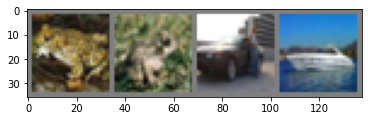

frog  frog  car   ship 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def backprop(self, x, y):
        """Return a tuple "(nabla_b, nabla_w)" representing the
        gradient for the cost function C_x.  "nabla_b" and
        "nabla_w" are layer-by-layer lists of numpy arrays, similar
        to "self.biases" and "self.weights"."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in xrange(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

...

net = Net()

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [6]:
for epoch in range(10):  # loop over the dataset multiple times
    all_acc = []
    train_acc = []
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
#        accs = (outputs.argmax(dim=-1) == labels.to('cpu')).float().mean()
#        train_accs.append(accs)
#    train_acc = sum(train_accs) / len(train_accs)
#    print(f"Accuracy of the network in {epoch + 1}th epoch on the 50000 train images: {train_acc:.5f}")
            
    net.eval()
    correct = 0
    total = 0
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
        # calculate outputs by running images through the network
            outputs = net(images)
        # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    all_acc.append(acc)
    print(f'Accuracy of the network in {epoch + 1}th epoch on the 10000 test images: {100 * correct // total} %')
print('Finished Training')

[1,  2000] loss: 2.183
[1,  4000] loss: 1.831
[1,  6000] loss: 1.655
[1,  8000] loss: 1.582
[1, 10000] loss: 1.543
[1, 12000] loss: 1.483
Accuracy of the network in 1th epoch on the 10000 test images: 47 %
[2,  2000] loss: 1.396
[2,  4000] loss: 1.372
[2,  6000] loss: 1.354
[2,  8000] loss: 1.315
[2, 10000] loss: 1.298
[2, 12000] loss: 1.278
Accuracy of the network in 2th epoch on the 10000 test images: 54 %
[3,  2000] loss: 1.211
[3,  4000] loss: 1.207
[3,  6000] loss: 1.189
[3,  8000] loss: 1.165
[3, 10000] loss: 1.184
[3, 12000] loss: 1.179
Accuracy of the network in 3th epoch on the 10000 test images: 59 %
[4,  2000] loss: 1.101
[4,  4000] loss: 1.097
[4,  6000] loss: 1.101
[4,  8000] loss: 1.090
[4, 10000] loss: 1.085
[4, 12000] loss: 1.091
Accuracy of the network in 4th epoch on the 10000 test images: 59 %
[5,  2000] loss: 1.035
[5,  4000] loss: 1.011
[5,  6000] loss: 1.036
[5,  8000] loss: 1.015
[5, 10000] loss: 1.055
[5, 12000] loss: 1.035
Accuracy of the network in 5th epoch o

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


net_1 = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_1.parameters(), lr=0.001, momentum=0.9)

# epoch
all_acc_1 = []
for epoch in range(10): 
    net_1.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        # forward & backward & optimize
        outputs = net_1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
            
    net_1.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net_1(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    all_acc_1.append(acc)
    print(f'Accuracy of the network in {epoch + 1}th epoch on the 10000 test images: {100 * correct // total} %')
print('Finished Training')

Accuracy of the network in 1th epoch on the 10000 test images: 42 %
Accuracy of the network in 2th epoch on the 10000 test images: 43 %
Accuracy of the network in 3th epoch on the 10000 test images: 43 %
Accuracy of the network in 4th epoch on the 10000 test images: 45 %
Accuracy of the network in 5th epoch on the 10000 test images: 46 %
Accuracy of the network in 6th epoch on the 10000 test images: 46 %
Accuracy of the network in 7th epoch on the 10000 test images: 46 %
Accuracy of the network in 8th epoch on the 10000 test images: 46 %
Accuracy of the network in 9th epoch on the 10000 test images: 46 %
Accuracy of the network in 10th epoch on the 10000 test images: 48 %
Finished Training


In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


net_2 = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_2.parameters(), lr=0.001, momentum=0.9)

# epoch
all_acc_2 = []
for epoch in range(10):
    net_2.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        outputs = net_2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
            
    net_2.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net_2(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    all_acc_2.append(acc)
    print(f'Accuracy of the network in {epoch + 1}th epoch on the 10000 test images: {100 * correct // total} %')
print('Finished Training')

Accuracy of the network in 1th epoch on the 10000 test images: 42 %
Accuracy of the network in 2th epoch on the 10000 test images: 46 %
Accuracy of the network in 3th epoch on the 10000 test images: 46 %
Accuracy of the network in 4th epoch on the 10000 test images: 46 %
Accuracy of the network in 5th epoch on the 10000 test images: 46 %
Accuracy of the network in 6th epoch on the 10000 test images: 46 %
Accuracy of the network in 7th epoch on the 10000 test images: 46 %
Accuracy of the network in 8th epoch on the 10000 test images: 48 %
Accuracy of the network in 9th epoch on the 10000 test images: 47 %
Accuracy of the network in 10th epoch on the 10000 test images: 47 %
Finished Training


In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.fc4(x)
        return x


net_3 = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_3.parameters(), lr=0.001, momentum=0.9)

# epoch
n_epochs = 10
all_acc_3 = []
for epoch in range(n_epochs):  
    net_3.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        outputs = net_3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
            
    net_3.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
        # calculate outputs by running images through the network
            outputs = net_3(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    all_acc_3.append(acc)
    print(f'Accuracy of the network in {epoch + 1}th epoch on the 10000 test images: {100 * correct // total} %')
print('Finished Training')

Accuracy of the network in 1th epoch on the 10000 test images: 41 %
Accuracy of the network in 2th epoch on the 10000 test images: 44 %
Accuracy of the network in 3th epoch on the 10000 test images: 47 %
Accuracy of the network in 4th epoch on the 10000 test images: 46 %
Accuracy of the network in 5th epoch on the 10000 test images: 47 %
Accuracy of the network in 6th epoch on the 10000 test images: 48 %
Accuracy of the network in 7th epoch on the 10000 test images: 49 %
Accuracy of the network in 8th epoch on the 10000 test images: 48 %
Accuracy of the network in 9th epoch on the 10000 test images: 49 %
Accuracy of the network in 10th epoch on the 10000 test images: 48 %
Finished Training


In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 512)
        self.fc5 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.fc5(x)
        return x


net_4 = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_4.parameters(), lr=0.001, momentum=0.9)

# epoch
n_epochs = 10
all_acc_4 = []
for epoch in range(n_epochs):  
    net_4.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        # forward & backward & optimize
        outputs = net_4(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
            
    net_4.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net_4(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    all_acc_4.append(acc)
    print(f'Accuracy of the network in {epoch + 1}th epoch on the 10000 test images: {100 * correct // total} %')
print('Finished Training')

Accuracy of the network in 1th epoch on the 10000 test images: 39 %
Accuracy of the network in 2th epoch on the 10000 test images: 43 %
Accuracy of the network in 3th epoch on the 10000 test images: 45 %
Accuracy of the network in 4th epoch on the 10000 test images: 45 %
Accuracy of the network in 5th epoch on the 10000 test images: 48 %
Accuracy of the network in 6th epoch on the 10000 test images: 48 %
Accuracy of the network in 7th epoch on the 10000 test images: 49 %
Accuracy of the network in 8th epoch on the 10000 test images: 49 %
Accuracy of the network in 9th epoch on the 10000 test images: 49 %
Accuracy of the network in 10th epoch on the 10000 test images: 49 %
Finished Training


In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 512)
        self.fc5 = nn.Linear(512, 512)
        self.fc6 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.dropout(F.relu(self.fc5(x)))
        x = self.fc6(x)
        return x


net_5 = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_5.parameters(), lr=0.001, momentum=0.9)

# epoch
n_epochs = 10
all_acc_5 = []
for epoch in range(n_epochs):  
    net_5.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net_5(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
            
    net_5.eval()
    correct = 0
    total = 0
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net_5(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    all_acc_5.append(acc)
    print(f'Accuracy of the network in {epoch + 1}th epoch on the 10000 test images: {100 * correct // total} %')
print('Finished Training')

Accuracy of the network in 1th epoch on the 10000 test images: 33 %
Accuracy of the network in 2th epoch on the 10000 test images: 41 %
Accuracy of the network in 3th epoch on the 10000 test images: 42 %
Accuracy of the network in 4th epoch on the 10000 test images: 45 %
Accuracy of the network in 5th epoch on the 10000 test images: 45 %
Accuracy of the network in 6th epoch on the 10000 test images: 47 %
Accuracy of the network in 7th epoch on the 10000 test images: 48 %
Accuracy of the network in 8th epoch on the 10000 test images: 49 %
Accuracy of the network in 9th epoch on the 10000 test images: 48 %
Accuracy of the network in 10th epoch on the 10000 test images: 49 %
Finished Training


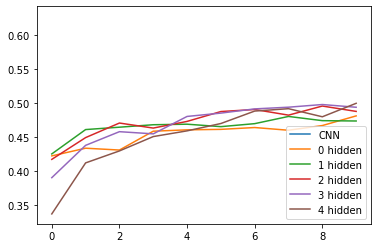

In [17]:
plt.plot(all_acc, label='CNN')
plt.plot(all_acc_1,label='0 hidden')
plt.plot(all_acc_2,label='1 hidden')
plt.plot(all_acc_3,label='2 hidden')
plt.plot(all_acc_4,label='3 hidden')
plt.plot(all_acc_5,label='4 hidden')
plt.legend(loc="lower right")
#plt.legend(['CNN','0 hidden','1 hidden','2 hidden','3 hidden','4 hidden'])
plt.show()

In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.sigmoid(self.conv1(x)))
        x = self.pool(F.sigmoid(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x


net_6 = Net()

# Define a Loss function and optimizer
# Let’s use a Classification Cross-Entropy loss and SGD with momentum.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_6.parameters(), lr=0.001, momentum=0.9)

# epoch
n_epochs = 10
all_acc_6 = []
for epoch in range(n_epochs):  
    net_6.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        outputs = net_6(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if i % 2000 == 1999:  
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    
            
    net_6.eval()
    correct = 0
    total = 0
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net_6(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    all_acc_6.append(acc)
    print(f'Accuracy of the network in {epoch + 1}th epoch on the 10000 test images: {100 * correct // total} %')
print('Finished Training')

/opt/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,  2000] loss: 0.000
[1,  4000] loss: 0.000
[1,  6000] loss: 0.000
[1,  8000] loss: 0.000
[1, 10000] loss: 0.000
[1, 12000] loss: 0.000
Accuracy of the network in 1th epoch on the 10000 test images: 10 %
[2,  2000] loss: 0.000
[2,  4000] loss: 0.000
[2,  6000] loss: 0.000
[2,  8000] loss: 0.000
[2, 10000] loss: 0.000
[2, 12000] loss: 0.000
Accuracy of the network in 2th epoch on the 10000 test images: 10 %
[3,  2000] loss: 0.000
[3,  4000] loss: 0.000
[3,  6000] loss: 0.000
[3,  8000] loss: 0.000
[3, 10000] loss: 0.000
[3, 12000] loss: 0.000
Accuracy of the network in 3th epoch on the 10000 test images: 10 %
[4,  2000] loss: 0.000
[4,  4000] loss: 0.000
[4,  6000] loss: 0.000
[4,  8000] loss: 0.000
[4, 10000] loss: 0.000
[4, 12000] loss: 0.000
Accuracy of the network in 4th epoch on the 10000 test images: 10 %
[5,  2000] loss: 0.000
[5,  4000] loss: 0.000
[5,  6000] loss: 0.000
[5,  8000] loss: 0.000
[5, 10000] loss: 0.000
[5, 12000] loss: 0.000
Accuracy of the network in 5th epoch o

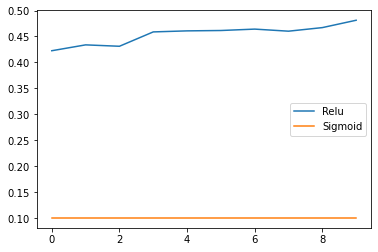

In [15]:
plt.plot(all_acc_1)
plt.plot(all_acc_6)
plt.legend(['Relu','Sigmoid'])
plt.show()

In [16]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net_7 = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_7.parameters(), lr=0.001, momentum=0.9)

# epoch
n_epochs = 20
all_acc_7 = []
train_acc = []
for epoch in range(n_epochs):  
    net_7.train()
    running_loss = 0.0
    train_accs=[]
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net_7(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            
    net_7.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net_7(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    all_acc_7.append(acc)
    print(f'Accuracy of the network in {epoch + 1}th epoch on the 10000 test images: {100 * correct // total} %')
print('Finished Training')

[1,  2000] loss: 0.000
[1,  4000] loss: 0.000
[1,  6000] loss: 0.000
[1,  8000] loss: 0.000
[1, 10000] loss: 0.000
[1, 12000] loss: 0.000
Accuracy of the network in 1th epoch on the 10000 test images: 47 %
[2,  2000] loss: 0.000
[2,  4000] loss: 0.000
[2,  6000] loss: 0.000
[2,  8000] loss: 0.000
[2, 10000] loss: 0.000
[2, 12000] loss: 0.000
Accuracy of the network in 2th epoch on the 10000 test images: 54 %
[3,  2000] loss: 0.000
[3,  4000] loss: 0.000
[3,  6000] loss: 0.000
[3,  8000] loss: 0.000
[3, 10000] loss: 0.000
[3, 12000] loss: 0.000
Accuracy of the network in 3th epoch on the 10000 test images: 57 %
[4,  2000] loss: 0.000
[4,  4000] loss: 0.000
[4,  6000] loss: 0.000
[4,  8000] loss: 0.000
[4, 10000] loss: 0.000
[4, 12000] loss: 0.000
Accuracy of the network in 4th epoch on the 10000 test images: 58 %
[5,  2000] loss: 0.000
[5,  4000] loss: 0.000
[5,  6000] loss: 0.000
[5,  8000] loss: 0.000
[5, 10000] loss: 0.000
[5, 12000] loss: 0.000
Accuracy of the network in 5th epoch o

In [18]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.dropout(self.pool(F.relu(self.conv1(x))))
        x = self.dropout(self.pool(F.relu(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


net_8 = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_8.parameters(), lr=0.001, momentum=0.9)

# epoch
n_epochs = 20
all_acc_8 = []
train_acc_2 = []
for epoch in range(n_epochs):  
    net_8.train()
    running_loss = 0.0
    train_accs=[]
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        # forward & backward & optimize & training accuracy
        outputs = net_8(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if i % 2000 == 1999:    
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
          
    net_8.eval()
    net_8.cpu()
    correct = 0
    total = 0
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
        # calculate outputs by running images through the network
            outputs = net_8(images)
        # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    all_acc_8.append(acc)
    print(f'Accuracy of the network in {epoch + 1}th epoch on the 10000 test images: {100 * correct // total} %')
print('Finished Training')

[1,  2000] loss: 0.000
[1,  4000] loss: 0.000
[1,  6000] loss: 0.000
[1,  8000] loss: 0.000
[1, 10000] loss: 0.000
[1, 12000] loss: 0.000
Accuracy of the network in 1th epoch on the 10000 test images: 43 %
[2,  2000] loss: 0.000
[2,  4000] loss: 0.000
[2,  6000] loss: 0.000
[2,  8000] loss: 0.000
[2, 10000] loss: 0.000
[2, 12000] loss: 0.000
Accuracy of the network in 2th epoch on the 10000 test images: 47 %
[3,  2000] loss: 0.000
[3,  4000] loss: 0.000
[3,  6000] loss: 0.000
[3,  8000] loss: 0.000
[3, 10000] loss: 0.000
[3, 12000] loss: 0.000
Accuracy of the network in 3th epoch on the 10000 test images: 51 %
[4,  2000] loss: 0.000
[4,  4000] loss: 0.000
[4,  6000] loss: 0.000
[4,  8000] loss: 0.000
[4, 10000] loss: 0.000
[4, 12000] loss: 0.000
Accuracy of the network in 4th epoch on the 10000 test images: 53 %
[5,  2000] loss: 0.000
[5,  4000] loss: 0.000
[5,  6000] loss: 0.000
[5,  8000] loss: 0.000
[5, 10000] loss: 0.000
[5, 12000] loss: 0.000
Accuracy of the network in 5th epoch o

In [19]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))],)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [20]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net_9 = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_9.parameters(), lr=0.001, momentum=0.9)

# epoch
n_epochs = 20
all_acc_9 = []
train_acc_3 = []
for epoch in range(n_epochs):  
    net_9.train()
    running_loss = 0.0
    train_accs=[]
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        outputs = net_9(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
          
    net_9.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net_9(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    all_acc_9.append(acc)
    print(f'Accuracy of the network in {epoch + 1}th epoch on the 10000 test images: {100 * correct // total} %')
print('Finished Training')

[1,  2000] loss: 0.000
[1,  4000] loss: 0.000
[1,  6000] loss: 0.000
[1,  8000] loss: 0.000
[1, 10000] loss: 0.000
[1, 12000] loss: 0.000
Accuracy of the network in 1th epoch on the 10000 test images: 36 %
[2,  2000] loss: 0.000
[2,  4000] loss: 0.000
[2,  6000] loss: 0.000
[2,  8000] loss: 0.000
[2, 10000] loss: 0.000
[2, 12000] loss: 0.000
Accuracy of the network in 2th epoch on the 10000 test images: 42 %
[3,  2000] loss: 0.000
[3,  4000] loss: 0.000
[3,  6000] loss: 0.000
[3,  8000] loss: 0.000
[3, 10000] loss: 0.000
[3, 12000] loss: 0.000
Accuracy of the network in 3th epoch on the 10000 test images: 43 %
[4,  2000] loss: 0.000
[4,  4000] loss: 0.000
[4,  6000] loss: 0.000
[4,  8000] loss: 0.000
[4, 10000] loss: 0.000
[4, 12000] loss: 0.000
Accuracy of the network in 4th epoch on the 10000 test images: 43 %
[5,  2000] loss: 0.000
[5,  4000] loss: 0.000
[5,  6000] loss: 0.000
[5,  8000] loss: 0.000
[5, 10000] loss: 0.000
[5, 12000] loss: 0.000
Accuracy of the network in 5th epoch o

In [21]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.dropout(self.pool(F.relu(self.conv1(x))))
        x = self.dropout(self.pool(F.relu(self.conv2(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


net_10 = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_10.parameters(), lr=0.001, momentum=0.9)

# epoch
n_epochs = 20
all_acc_10 = []
train_acc_4 = []
for epoch in range(n_epochs): 
    net_10.train()
    running_loss = 0.0
    train_accs=[]
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net_10(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    
    net_10.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net_10(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    all_acc_10.append(acc)
    print(f'Accuracy of the network in {epoch + 1}th epoch on the 10000 test images: {100 * correct // total} %')
print('Finished Training')

[1,  2000] loss: 0.000
[1,  4000] loss: 0.000
[1,  6000] loss: 0.000
[1,  8000] loss: 0.000
[1, 10000] loss: 0.000
[1, 12000] loss: 0.000
Accuracy of the network in 1th epoch on the 10000 test images: 30 %
[2,  2000] loss: 0.000
[2,  4000] loss: 0.000
[2,  6000] loss: 0.000
[2,  8000] loss: 0.000
[2, 10000] loss: 0.000
[2, 12000] loss: 0.000
Accuracy of the network in 2th epoch on the 10000 test images: 35 %
[3,  2000] loss: 0.000
[3,  4000] loss: 0.000
[3,  6000] loss: 0.000
[3,  8000] loss: 0.000
[3, 10000] loss: 0.000
[3, 12000] loss: 0.000
Accuracy of the network in 3th epoch on the 10000 test images: 37 %
[4,  2000] loss: 0.000
[4,  4000] loss: 0.000
[4,  6000] loss: 0.000
[4,  8000] loss: 0.000
[4, 10000] loss: 0.000
[4, 12000] loss: 0.000
Accuracy of the network in 4th epoch on the 10000 test images: 40 %
[5,  2000] loss: 0.000
[5,  4000] loss: 0.000
[5,  6000] loss: 0.000
[5,  8000] loss: 0.000
[5, 10000] loss: 0.000
[5, 12000] loss: 0.000
Accuracy of the network in 5th epoch o

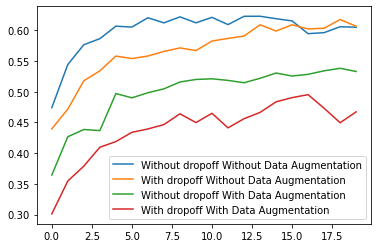

In [23]:
plt.plot(all_acc_7)
plt.plot(all_acc_8)
plt.plot(all_acc_9)
plt.plot(all_acc_10)
plt.legend(['Without dropoff Without Data Augmentation','With dropoff Without Data Augmentation','Without dropoff With Data Augmentation','With dropoff With Data Augmentation'])
plt.show()